In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Set the font family to Times New Roman


In [2]:
df_imagenet = pd.read_csv('./archive_results/imagenet_results.csv')

In [3]:
df_cifar10 = pd.read_csv('./archive_results/cifar10_results.csv')

In [4]:
df_cifar100 = pd.read_csv('./archive_results/cifar100_results.csv')

In [5]:
def get_ece_15_bins(ece_str):
    ece_data = eval(ece_str)
    for ece_entry in ece_data:
        if ece_entry['n_bins'] == 15:
            return ece_entry['result']
    return None



In [6]:
def get_value_15_bins(metric_str, metric_name):
    try:
        metric_data_list = eval(metric_str)
    except Exception as e:
        print(f"Error while evaluating metric_str: {e}")
        return None

    if metric_name in ['KSCE', 'KDECE', 'MMCE', 'NLL', 'brier']:
        try:
            if isinstance(metric_data_list, dict) and 'result' in metric_data_list:
                return metric_data_list['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            return None

    for metric_data in metric_data_list:
        try:
            if 'n_bins' in metric_data and metric_data['n_bins'] == 15:
                return metric_data['result']
            elif 'num_bins' in metric_data and metric_data['num_bins'] == 15 and metric_data['mode'] == 'top-label' and not metric_data['debias']:
                return metric_data['result']
        except Exception as e:
            print(f"Error while processing metric_data: {e}")
            continue

    return None



In [7]:
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_path = 'fig/times.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

In [8]:
metrics_to_extract = [
    'ece', 'ECE_em', 'cwECE', 'tace', 'KSCE', 'KDECE', 'MMCE'
]

for metric in metrics_to_extract:
    for dataset, df in [('imagenet', df_imagenet), ('cifar10', df_cifar10), ('cifar100', df_cifar100)]:
        column_name = f"{metric}_{dataset}"
        df[column_name] = df[metric].apply(lambda x: get_value_15_bins(x, metric))

Error while evaluating metric_str: name 'nan' is not defined
Error while evaluating metric_str: name 'nan' is not defined


In [9]:
merged_df = df_imagenet[['config'] + [f"{metric}_imagenet" for metric in metrics_to_extract]].merge(
    df_cifar10[['config'] + [f"{metric}_cifar10" for metric in metrics_to_extract]], on='config', how='outer'
).merge(
    df_cifar100[['config'] + [f"{metric}_cifar100" for metric in metrics_to_extract]], on='config', how='outer'
)

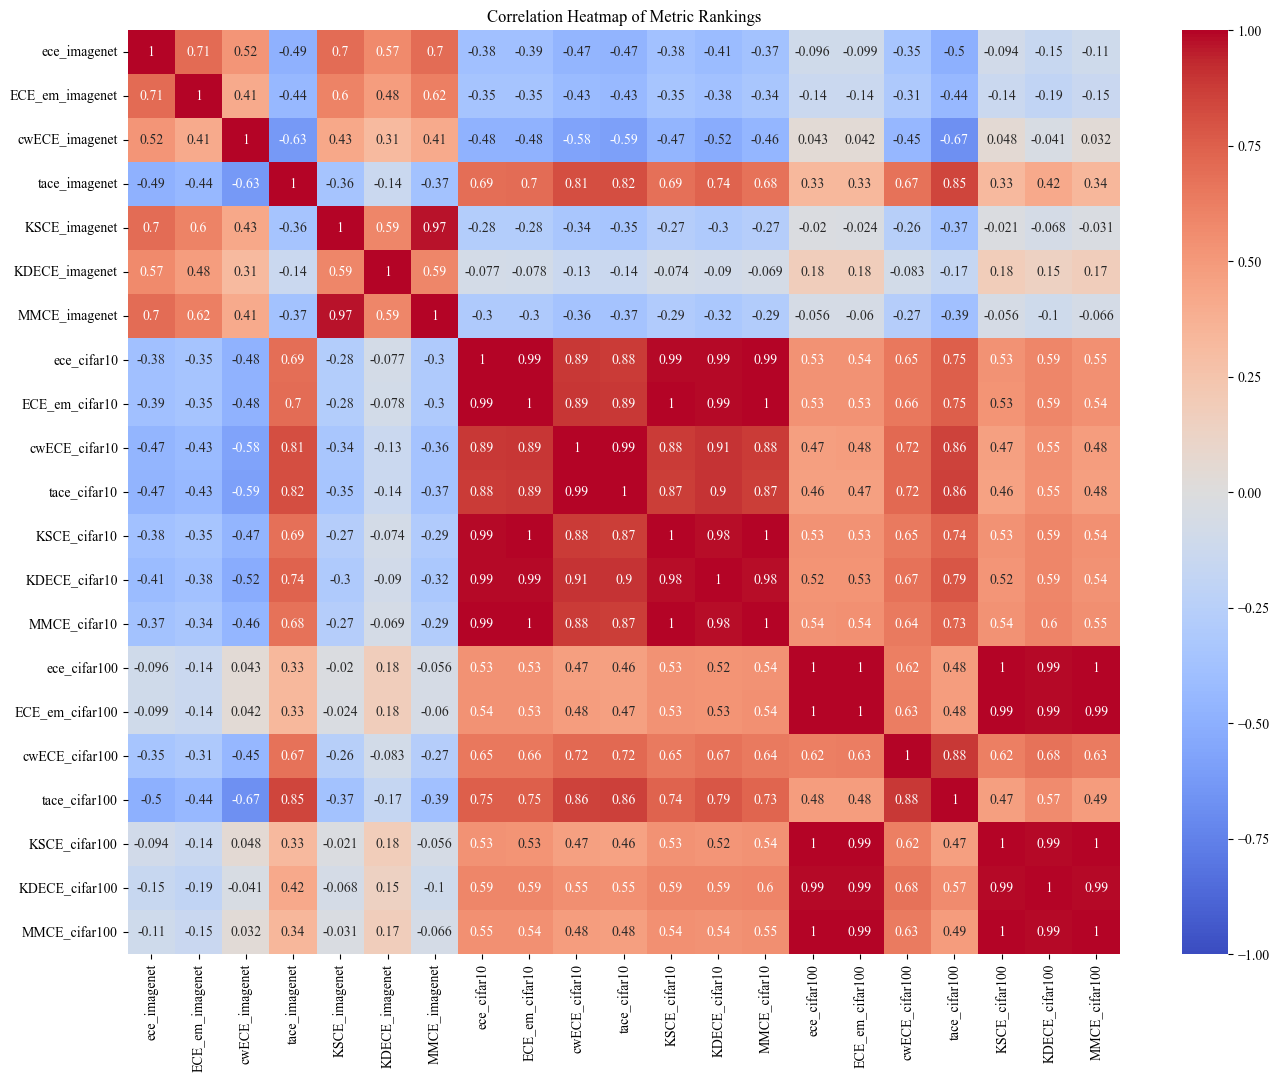

In [10]:
# Create new columns with the ranking of each metric for config
for metric in metrics_to_extract:
    for dataset in ['imagenet', 'cifar10', 'cifar100']:
        column_name = f"{metric}_{dataset}"
        rank_column_name = f"{metric}_{dataset}"
        merged_df[rank_column_name] = merged_df[column_name].rank(method='dense', ascending=False)

# Calculate the correlation matrix for the metric rankings
rank_columns = [f"{metric}_{dataset}" for dataset in ['imagenet', 'cifar10', 'cifar100'] for metric in metrics_to_extract]
corr_matrix = merged_df[rank_columns].corr()

# Create a correlation heatmap using seaborn
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Metric Rankings")
plt.savefig("fig/Correlation_Heatmap_of_Metric_Rankings.pdf", dpi=300, format='pdf', bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>